In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [15]:
# Load map and extract Belgium/Netherlands regions
map = cv2.imread('data/Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:, :, (2, 1, 0)]

belgium_color = np.array([251, 234, 81])
netherlands_color = np.array([255, 255, 228])

netherlands_region = ((map - netherlands_color)**2).sum(-1) < 50
belgium_region = ((map - belgium_color)**2).sum(-1) < 10000

b_coords = np.array(np.where(belgium_region)).T.astype('float')
n_coords = np.array(np.where(netherlands_region)).T.astype('float')

# Flip and normalize coordinates to [-1, 1]
belgium_coords_all = np.zeros_like(b_coords)
netherlands_coords_all = np.zeros_like(n_coords)

belgium_coords_all[:, 0] = b_coords[:, 1] / (960 / 2) - 1
belgium_coords_all[:, 1] = (960 - b_coords[:, 0]) / (960 / 2) - 1
netherlands_coords_all[:, 0] = n_coords[:, 1] / (960 / 2) - 1
netherlands_coords_all[:, 1] = (960 - n_coords[:, 0]) / (960 / 2) - 1

In [16]:
np.random.seed(55)
num_points_to_sample = 10000
belgium_coords_sample = belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords_sample = netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]
X_sample = np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample = np.concatenate((np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))).astype('int')
X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

In [17]:
# Full dataset (no sampling)
belgium_coords = belgium_coords_all
netherlands_coords = netherlands_coords_all

X = np.vstack((netherlands_coords, belgium_coords))
y = np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [18]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers = layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [19]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig = plt.figure(0, (6, 6))
    ax = fig.add_subplot(111)

    probe = np.zeros((res, res, 2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k] = [yy, xx]
    probe = probe.reshape(res**2, -1)
    probe_logits = model(torch.tensor(probe).float().to(device))
    probe_logits = probe_logits.detach().cpu().numpy().reshape(res, res, 2)

    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits, 2)),
               extent=[0, 960, 960, 0],
               alpha=0.7,
               cmap='viridis')

## Figure 4.1

In [20]:
# ============================================================================
# Figure 4.1: 3 Hidden Neurons
# ============================================================================

batch_size = 10000
random_seed = 26

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 3

Epoch [1/3], Loss: 0.3802, Accuracy: 0.6721
Epoch [2/3], Loss: 0.3523, Accuracy: 0.6699
Epoch [3/3], Loss: 0.3522, Accuracy: 0.6698


<Figure size 640x480 with 0 Axes>

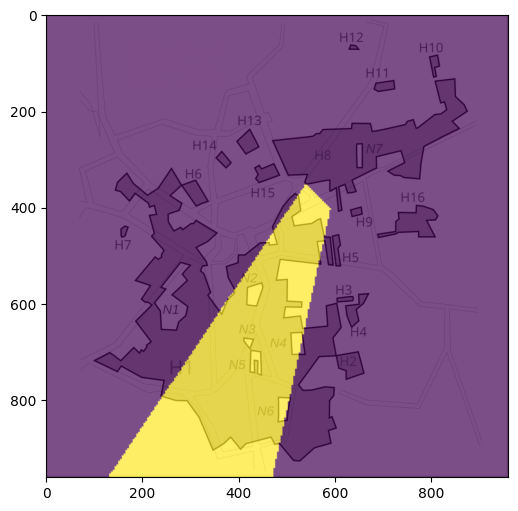

In [21]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Calculate accuracy on sample dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)

## Figure 4.4

In [22]:
# ============================================================================
# Figure 4.4: 8 Hidden Neurons
# ============================================================================

batch_size = 10000
random_seed = 26

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 3

Epoch [1/3], Loss: 0.3080, Accuracy: 0.7673
Epoch [2/3], Loss: 0.2362, Accuracy: 0.8384
Epoch [3/3], Loss: 0.2095, Accuracy: 0.8413


<Figure size 640x480 with 0 Axes>

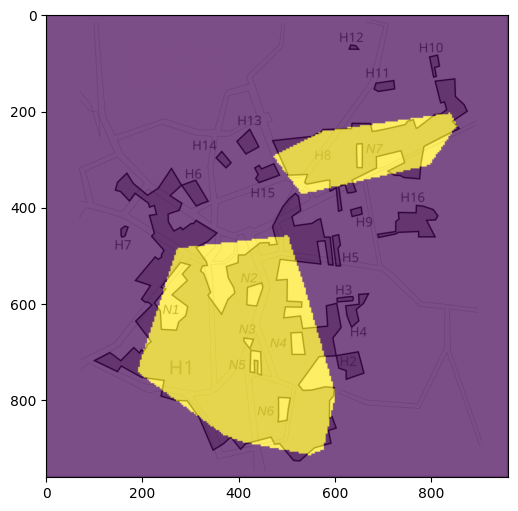

In [23]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Calculate accuracy on sample dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)

## Figure 4.5

### Small Model

In [24]:
# ============================================================================
# Figure 4.5: 16 Hidden Neurons
# ============================================================================

batch_size = 10000
random_seed = 26

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 5

Epoch [1/5], Loss: 0.3273, Accuracy: 0.7666
Epoch [2/5], Loss: 0.2489, Accuracy: 0.7891
Epoch [3/5], Loss: 0.2214, Accuracy: 0.8399
Epoch [4/5], Loss: 0.2065, Accuracy: 0.8591
Epoch [5/5], Loss: 0.2038, Accuracy: 0.8540


<Figure size 640x480 with 0 Axes>

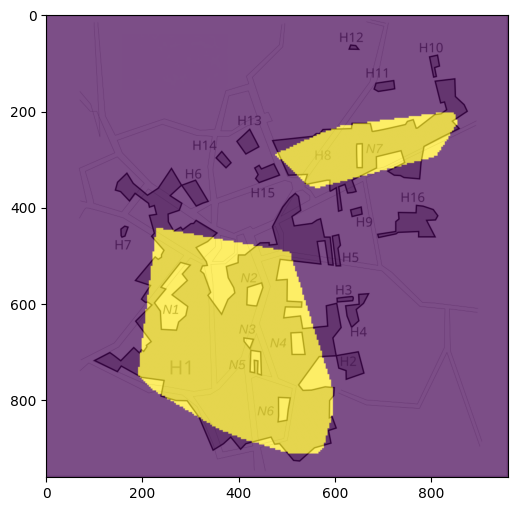

In [25]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Calculate accuracy on sample dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)

### Medium Model

In [26]:
# ============================================================================
# Figure 4.5: 32 Hidden Neurons
# ============================================================================

batch_size = 10000
random_seed = 1

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([32]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 100

Epoch [1/100], Loss: 0.3100, Accuracy: 0.7909
Epoch [2/100], Loss: 0.2230, Accuracy: 0.8462
Epoch [3/100], Loss: 0.2051, Accuracy: 0.8672
Epoch [4/100], Loss: 0.1946, Accuracy: 0.8543
Epoch [5/100], Loss: 0.1890, Accuracy: 0.8590
Epoch [6/100], Loss: 0.1871, Accuracy: 0.8716
Epoch [7/100], Loss: 0.1846, Accuracy: 0.8580
Epoch [8/100], Loss: 0.1828, Accuracy: 0.8562
Epoch [9/100], Loss: 0.1815, Accuracy: 0.8592
Epoch [10/100], Loss: 0.1811, Accuracy: 0.8718
Epoch [11/100], Loss: 0.1795, Accuracy: 0.8618
Epoch [12/100], Loss: 0.1790, Accuracy: 0.8767
Epoch [13/100], Loss: 0.1789, Accuracy: 0.8812
Epoch [14/100], Loss: 0.1790, Accuracy: 0.8671
Epoch [15/100], Loss: 0.1789, Accuracy: 0.8576
Epoch [16/100], Loss: 0.1775, Accuracy: 0.8487
Epoch [17/100], Loss: 0.1772, Accuracy: 0.8590
Epoch [18/100], Loss: 0.1771, Accuracy: 0.8751
Epoch [19/100], Loss: 0.1777, Accuracy: 0.8721
Epoch [20/100], Loss: 0.1769, Accuracy: 0.8580
Epoch [21/100], Loss: 0.1771, Accuracy: 0.8449
Epoch [22/100], Loss: 

<Figure size 640x480 with 0 Axes>

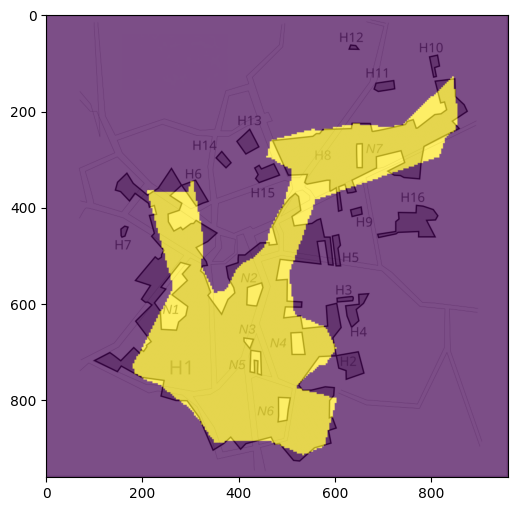

In [27]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on sample dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)

### Large Model

In [28]:
# ============================================================================
# Figure 4.5: 64 Hidden Neurons
# ============================================================================

batch_size = 10000
random_seed = 1

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 100

Epoch [1/100], Loss: 0.2821, Accuracy: 0.8278
Epoch [2/100], Loss: 0.2059, Accuracy: 0.8470
Epoch [3/100], Loss: 0.1955, Accuracy: 0.8533
Epoch [4/100], Loss: 0.1899, Accuracy: 0.8401
Epoch [5/100], Loss: 0.1847, Accuracy: 0.8529
Epoch [6/100], Loss: 0.1791, Accuracy: 0.8779
Epoch [7/100], Loss: 0.1757, Accuracy: 0.8459
Epoch [8/100], Loss: 0.1727, Accuracy: 0.8508
Epoch [9/100], Loss: 0.1697, Accuracy: 0.8639
Epoch [10/100], Loss: 0.1681, Accuracy: 0.8836
Epoch [11/100], Loss: 0.1659, Accuracy: 0.8800
Epoch [12/100], Loss: 0.1634, Accuracy: 0.8826
Epoch [13/100], Loss: 0.1631, Accuracy: 0.8663
Epoch [14/100], Loss: 0.1628, Accuracy: 0.8719
Epoch [15/100], Loss: 0.1606, Accuracy: 0.8804
Epoch [16/100], Loss: 0.1604, Accuracy: 0.8711
Epoch [17/100], Loss: 0.1596, Accuracy: 0.8788
Epoch [18/100], Loss: 0.1596, Accuracy: 0.8924
Epoch [19/100], Loss: 0.1595, Accuracy: 0.8797
Epoch [20/100], Loss: 0.1602, Accuracy: 0.8889
Epoch [21/100], Loss: 0.1571, Accuracy: 0.8849
Epoch [22/100], Loss: 

<Figure size 640x480 with 0 Axes>

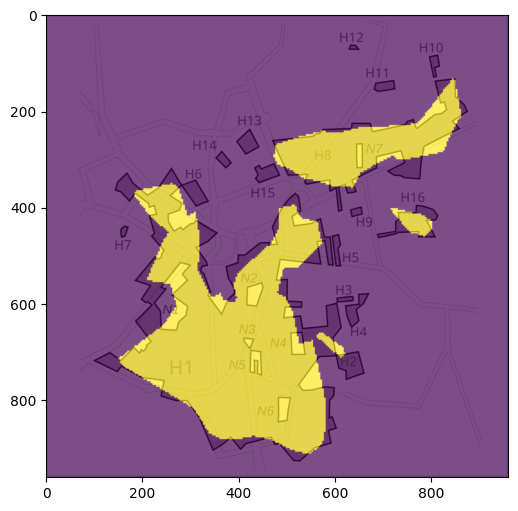

In [29]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on sample dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)

Epoch [1/100], Loss: 0.2713, Accuracy: 0.8372
Epoch [2/100], Loss: 0.2008, Accuracy: 0.8350
Epoch [3/100], Loss: 0.1898, Accuracy: 0.8663
Epoch [4/100], Loss: 0.1838, Accuracy: 0.8639
Epoch [5/100], Loss: 0.1792, Accuracy: 0.8789
Epoch [6/100], Loss: 0.1749, Accuracy: 0.8865
Epoch [7/100], Loss: 0.1727, Accuracy: 0.8787
Epoch [8/100], Loss: 0.1708, Accuracy: 0.8770
Epoch [9/100], Loss: 0.1687, Accuracy: 0.8803
Epoch [10/100], Loss: 0.1676, Accuracy: 0.8873
Epoch [11/100], Loss: 0.1658, Accuracy: 0.8831
Epoch [12/100], Loss: 0.1647, Accuracy: 0.8674
Epoch [13/100], Loss: 0.1646, Accuracy: 0.8730
Epoch [14/100], Loss: 0.1623, Accuracy: 0.9022
Epoch [15/100], Loss: 0.1627, Accuracy: 0.8867
Epoch [16/100], Loss: 0.1599, Accuracy: 0.8703
Epoch [17/100], Loss: 0.1609, Accuracy: 0.8780
Epoch [18/100], Loss: 0.1575, Accuracy: 0.8821
Epoch [19/100], Loss: 0.1546, Accuracy: 0.8850
Epoch [20/100], Loss: 0.1537, Accuracy: 0.8802
Epoch [21/100], Loss: 0.1540, Accuracy: 0.8682
Epoch [22/100], Loss: 

<Figure size 640x480 with 0 Axes>

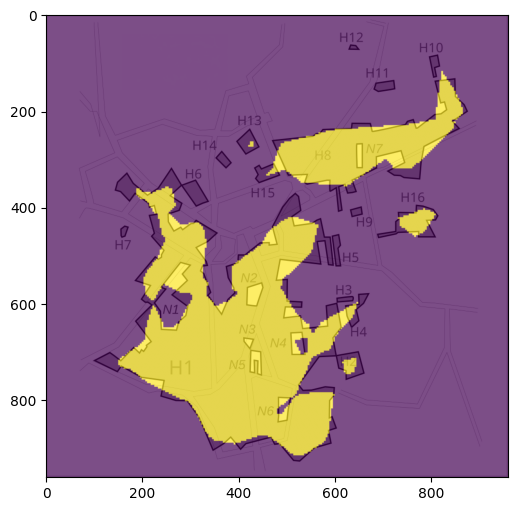

In [30]:
# ============================================================================
# Figure 4.5: 128 Hidden Neurons
# ============================================================================

batch_size = 10000
random_seed = 1

torch.manual_seed(random_seed)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([128]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches

    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on sample dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

viz_descision_boundary(model)


## Figure 4.14

In [31]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

In [32]:
map = cv2.imread('data/Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color = np.array([251, 234, 81])
netherlands_color = np.array([255, 255, 228])

netherlands_region = ((map - netherlands_color)**2).sum(-1) < 10
belgium_region = ((map - belgium_color)**2).sum(-1) < 10000

num_points_to_sample = 10000

b_coords = np.array(np.where(belgium_region)).T.astype('float')
n_coords = np.array(np.where(netherlands_region)).T.astype('float')

# Flip and normalize
belgium_coords_all = np.zeros_like(b_coords)
netherlands_coords_all = np.zeros_like(n_coords)

belgium_coords_all[:,0] = b_coords[:,1]/(960/2) - 1
belgium_coords_all[:,1] = (960 - b_coords[:,0])/(960/2) - 1
netherlands_coords_all[:,0] = n_coords[:,1]/(960/2) - 1
netherlands_coords_all[:,1] = (960 - n_coords[:,0])/(960/2) - 1

belgium_coords = belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords = netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X = np.vstack((netherlands_coords, belgium_coords))
y = np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI = np.arange(len(y))
np.random.shuffle(rI)
X = X[rI,:]
y = y[rI]

In [33]:
class BaarleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 2)
        )
    
    def forward(self, x):
        return self.model(x)

In [34]:
model = BaarleNet()
model.load_state_dict(torch.load('data/2_1.pth'))
model.eval()

BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)

In [35]:
print("First layer (input → hidden):")
print("W1 =", model.model[0].weight.data.numpy())
print("b1 =", model.model[0].bias.data.numpy())
print("\nSecond layer (hidden → output):")
print("W2 =", model.model[2].weight.data.numpy())
print("b2 =", model.model[2].bias.data.numpy())

First layer (input → hidden):
W1 = [[ 2.513498  -1.024808 ]
 [-1.404299   2.4129117]]
b1 = [-1.2398118  -0.45007765]

Second layer (hidden → output):
W2 = [[ 3.170242   1.3256735]
 [-3.4037237 -1.5387845]]
b2 = [-0.8848354   0.03322279]


In [36]:
x_test = np.array([0.6, 0.4])
x_belgium = torch.tensor(x_test, dtype=torch.float32)
print("Input:", x_test)

Input: [0.6 0.4]


In [37]:
with torch.no_grad():
    # First layer (before ReLU)
    h1_pre = model.model[0](x_belgium)
    print("After first linear layer (before ReLU):", h1_pre.numpy())
    
    # After ReLU
    h1_post = model.model[:2](x_belgium)
    print("After ReLU activation:", h1_post.numpy())
    
    # Output layer
    output = model(x_belgium)
    print("Final output (Netherlands, Belgium):", output.numpy())

After first linear layer (before ReLU): [-0.14163601 -0.32749242]
After ReLU activation: [0. 0.]
Final output (Netherlands, Belgium): [-0.8848354   0.03322279]


In [38]:
# Extract weights
W1 = model.model[0].weight.data.numpy()
b1 = model.model[0].bias.data.numpy()
W2 = model.model[2].weight.data.numpy()
b2 = model.model[2].bias.data.numpy()

x = x_test

# First layer computation
h1_pre = W1 @ x + b1
print("First layer (before ReLU):", h1_pre)

# ReLU activation
h1_post = np.maximum(0, h1_pre)
print("After ReLU:", h1_post)

# Second layer computation
output = W2 @ h1_post + b2
print("Final output:", output)
print("Predicted class:", "Belgium" if output[1] > output[0] else "Netherlands")

First layer (before ReLU): [-0.14163616 -0.3274924 ]
After ReLU: [0. 0.]
Final output: [-0.88483542  0.03322279]
Predicted class: Belgium


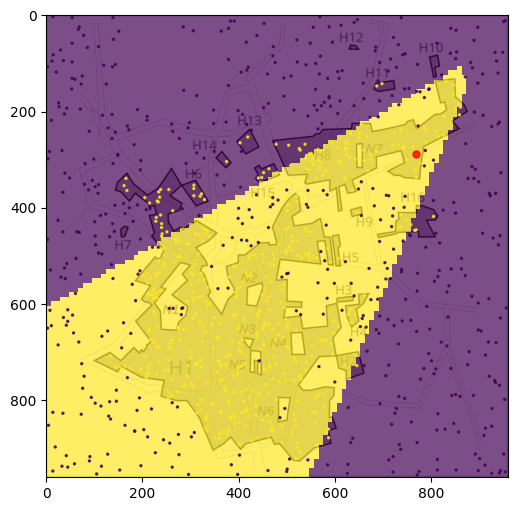

In [39]:
fig = plt.figure(0, (6, 6))
ax = fig.add_subplot(111)

ax.imshow(map.mean(2), cmap='gray')

X_denorm = denorm(X[:1000,:])
plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)

X_denorm = denorm(x_test)
plt.scatter(X_denorm[0], X_denorm[1], c='r', s=25, alpha=0.8)

probe = np.zeros((100, 100, 2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k] = [yy, xx]
probe = probe.reshape(100**2, -1)
probe_logits = model(torch.tensor(probe).float())
probe_logits = probe_logits.detach().numpy().reshape(100, 100, 2)
ax.imshow(np.flipud(np.argmax(probe_logits, 2)), 
           extent=[0, 960, 960, 0],
           alpha=0.7,
           cmap='viridis')